# Data Science Fundamentals, Assignment 3

In [1]:
import numpy as np
from  scipy import sparse
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from random import shuffle
from collections import Counter
from glob import glob
import sys
import json
import heapq
from tempfile import TemporaryFile
%matplotlib inline

# Cleaning and Preprocessing

This is being used to convert all the JSON files to CSV files, 
reference : https://gist.github.com/paulgb/5265767

In [ ]:
def convert(x):
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

for json_filename in glob('*.json'):
    csv_filename = '%s.csv' % json_filename[:-5]
    print 'Converting %s to %s' % (json_filename, csv_filename)
    df = pd.DataFrame([convert(line) for line in file(json_filename)])
    df.to_csv(csv_filename, encoding='utf-8', index=False)

Storing business ids in a separate csv, after dropping NaN's if any

In [ ]:
df_business = pd.read_csv('data/yelp_academic_dataset_business.csv')
business_ids = pd.DataFrame(df_business['business_id'])
business_ids = business_ids.dropna(how='any')
business_ids.to_csv('data/business_ids.csv', index=False)

Storing user ids in a separate csv, after dropping NaN's if any

In [ ]:
df_user = pd.read_csv('data/yelp_academic_dataset_user.csv')
user_ids = pd.DataFrame(df_user['user_id'])
user_ids = user_ids.dropna(how='any')
user_ids.to_csv('data/user_ids.csv', index = False)

storing edges (user id, business id) pair in a separate csv, dropping NaN's if any

In [ ]:
reviews = pd.read_csv('data/yelp_academic_dataset_review.csv')
review_edges = pd.DataFrame()
review_edges['user_id'] = reviews['user_id']
review_edges['business_id'] = reviews['business_id']
review_edges.to_csv('data/review_edges.csv', index=False)

Reading business and user ids from the csv files that we stored earlier 

In [2]:
business_ids = pd.read_csv('data/business_ids.csv')
user_ids = pd.read_csv('data/user_ids.csv')
USERS = user_ids['user_id'].as_matrix()
BIZS = business_ids['business_id'].as_matrix()

There can be few ids which are comman in both users and businesses,
this can create a issue since our assumption is ids are unique accross nodes 
removing these comman ids, and storing clean result in csv 

In [3]:
comman_ids = np.intersect1d(USERS, BIZS)

USERS = np.setdiff1d(USERS,comman_ids)
users_clean = pd.DataFrame(USERS)
users_clean.to_csv('data/users_ids_clean.csv', index=False)

BIZS = np.setdiff1d(BIZS, comman_ids)
bizs_clean = pd.DataFrame(BIZS)
bizs_clean.to_csv('data/bizs_ids_clean.csv',index=False)

Storing numbers of user and business for later use

In [4]:
no_bizs = BIZS.shape[0]
no_usrs = USERS.shape[0]
print(no_bizs)
print(no_usrs)

84971
685626


Reading clean ids to build edges

In [5]:
USERS = pd.read_csv('data/users_ids_clean.csv').as_matrix()
BIZS = pd.read_csv('data/bizs_ids_clean.csv').as_matrix()

Reading review file that we stored in earlier part

In [6]:
review_edges = pd.read_csv('data/review_edges.csv')
EDGES_MAT = review_edges.as_matrix()

We are testing if there are some values of user ids in edges data, which are invalid,
because they are not part of user data, these edges will be invalid,
We are removing Invalid edges, and making sure the remaining edges are all valid.

In [7]:
truthArray = np.in1d(EDGES_MAT[:,0], USERS)
staleIndexs = np.where(truthArray == False)
EDGES_MAT = np.delete(EDGES_MAT, staleIndexs[0], 0)
truthvalidation = np.all(np.in1d(EDGES_MAT[:,0], USERS))

# checking if we successfully removed invalid edges
print(truthvalidation)

/home/shilpa/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


True


We are testing if there are some values of business ids in edges data, which are invalid,
because they are not part of busines data, these edges will be invalid,
We are removing Invalid edges and making sure that remaining edges are all valid.

In [8]:
truthArray = np.in1d(EDGES_MAT[:,1],BIZS)
staleIndexs = np.where(truthArray == False)
EDGES_MAT = np.delete(EDGES_MAT, staleIndexs[0],0)
truthvalidation = np.all(np.in1d(EDGES_MAT[:,1], BIZS))
print(truthvalidation)

True


saving these clean edges in csv

In [9]:
edges_clean = pd.DataFrame(EDGES_MAT)
edges_clean.to_csv('data/edges_clean.csv',index=False)

Combining all nodes of our graph, and storing

In [10]:
USERS = pd.read_csv('data/users_ids_clean.csv').as_matrix()
BIZS = pd.read_csv('data/bizs_ids_clean.csv').as_matrix()

NODES = np.concatenate((USERS, BIZS), axis=0)
NODES = NODES.T[0]
nodes_clean = pd.DataFrame(NODES)
nodes_clean.to_csv('data/nodes_clean.csv', index=False)

Converting edges in the form of index representation for the creation of csr matrix

In [11]:
NODES = pd.read_csv('data/nodes_clean.csv').as_matrix()
EDGES_MAT = pd.read_csv('data/edges_clean.csv').as_matrix()
NODES = NODES.T[0]
Sorter = NODES.argsort()
EDGES = Sorter[np.searchsorted(NODES, EDGES_MAT,side='left',sorter = Sorter)]

Now Since we are interested in undirected graph
we are going to mark an edges i-->j as well if there is 
a edge from j --> i exits

In [13]:
src = EDGES[:,0]
dest = EDGES[:,1]
row = np.append(src,dest)
col = np.append(dest,src)

Building a csr matrix containing NODES (users + business)
If there is an edge between i and j node adge it will be represented as the entry in Matrix at position [j,i] as well as position [i,j] since it is an undirected graph.
ref : http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html

In [14]:
edgesize = EDGES[:,0].size
nodes = NODES.size
csr = sparse.csr_matrix((np.bool_(np.ones(2*edgesize)), (row, col)), shape=(nodes,nodes))
print "The size in memory of the adjacency matrix is {0} MB".format(
    (sys.getsizeof(csr.shape)+
    csr.data.nbytes+
    csr.indices.nbytes+
    csr.indptr.nbytes)/(1024.0**2)
)
print(csr.shape)

The size in memory of the adjacency matrix is 27.4653663635 MB
(770597, 770597)


saving routine of csr matrix for future use

In [17]:
def csr_save(filename,csr):
    np.savez(filename,
        rows=csr.shape[0],
        cols=csr.shape[1],
        edges=csr.data.size,
        indices=csr.indices,
        indptr =csr.indptr
    )

loading routine of csr matrix for future use

In [18]:
def csr_load(filename):
    loader = np.load(filename)
    edges = int(loader['edges'])
    return sparse.csr_matrix(
        (np.bool_(np.ones(edges)), loader['indices'], loader['indptr']),
        shape = (loader['rows'],loader['cols'])
    )

In [19]:
DATASET_NATIVE = 'data/dataset-native.npz'
csr_save(DATASET_NATIVE,csr)

# TASK 1

Loading csr matrix that we stored

In [20]:
DATASET_NATIVE = 'data/dataset-native.npz'
%time csr = csr_load(DATASET_NATIVE)

CPU times: user 100 ms, sys: 80 ms, total: 180 ms
Wall time: 351 ms


Since we have made the undirected matrix, the column or row sum of the matrix will give us the degree distribution of users 
and businesses, we are taking column sum

In [21]:
degrees = csr.sum(axis=0)
usr_degrees = degrees[0,0:no_usrs]
usr_degrees = usr_degrees.flatten()

biz_degrees = degrees[0,no_usrs:]
biz_degrees = biz_degrees.flatten()


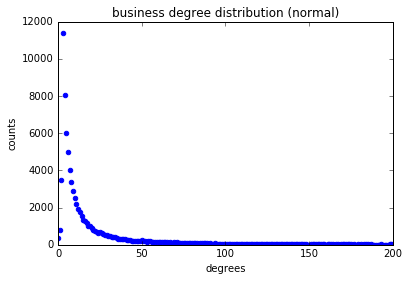

In [22]:
x = biz_degrees.flat
y = Counter(list(x))
distribution = np.array([y.keys(),y.values()])
plt.scatter(distribution[0,:],distribution[1,:], color='blue')
# trying to zoom out in lower part of the distribution
plt.xlim(0,200)
plt.ylim(0,12000)
plt.xlabel("degrees")
plt.ylabel("counts")
plt.title("business degree distribution (normal)")
plt.show()

Observations :

If we look at first distribution (for normal values), It looks like an exponential relationship between 
particular number of reviews and probability of getting that many reviews for an randomly selected business.

Let say we randomly select a perticular business X, the probabality that this business have received 2 reviews is very high, the probability that this business have 3 reviews decreases exponentialy.

the probability of a randomly selected business having k reviews decreases exponentialy if we increases k.

This kind of distribution can be classified as power low distrubution.
Let's look at the distribution if we take logs, (idealy it should look somewhat linear, if our assumption of it being a power low distribution is true)



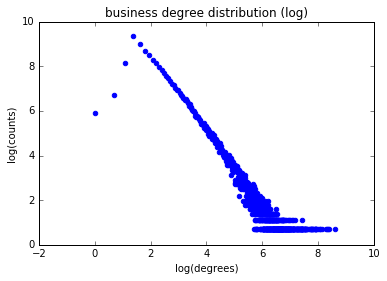

In [23]:
x = biz_degrees.flat
y = Counter(list(x))
distribution = np.array([y.keys(),y.values()])

# we are adding plus 1 to avoid -inft if we get 0 and degree count somewhere in data
x = np.log(distribution[0,:]+1)
y = np.log(distribution[1,:]+1)
plt.scatter(x,y, color='blue')
plt.title("business degree distribution (log)")
plt.xlabel('log(degrees)')
plt.ylabel('log(counts)')
plt.show()

Observations :
This almost looks like an linear relationship between log(count) and log(degrees), we can conclude that 
our assumtion of it being a power low distribution is true.
    
there are some flow breaking points at the start, but after k=2 it becomes a power low distribution.
    
In such scenarios of distribution generaly logrithmic graphs gives us more information because it looks much    simpler and it is easy to draw a relationship between 2 variables.

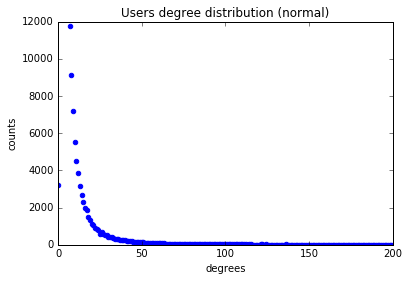

In [24]:
x = usr_degrees.flat
y = Counter(list(x))
distribution = np.array([y.keys(),y.values()])
plt.scatter(distribution[0,:],distribution[1,:], color='blue')
# trying to zoom out in lower part of the distribution
plt.xlim(0,200)
plt.ylim(0,12000)
plt.xlabel("degrees")
plt.ylabel("counts")
plt.title("Users degree distribution (normal)")
plt.show()

Observations :

This time this is more clear power low distribution same as in case of business, it does not have any outliers as well.

It means if k denot number of reviews than, if we select an user randomly, the pobability of that user has reviewed k businesses decreses exponentialy if we increase k.

it should also be a linear graph when we plot it in log scale.

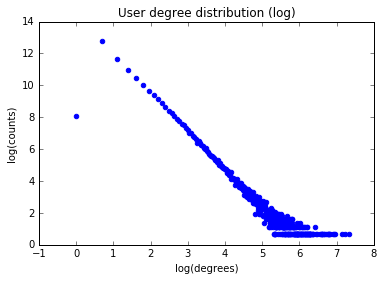

In [25]:
x = usr_degrees.flat
y = Counter(list(x))
distribution = np.array([y.keys(),y.values()])

# we are adding plus 1 to avoid -inft if we get 0 and degree count somewhere in data
x = np.log(distribution[0,:]+1)
y = np.log(distribution[1,:]+1)
plt.scatter(x,y, color='blue')
plt.title("User degree distribution (log)")
plt.xlabel('log(degrees)')
plt.ylabel('log(counts)')
plt.show()

Observations :
As expected this as well is a linear plot between log(degrees) and log(count).

# TASK 2 :

loading the CSR matrix that we made

In [26]:
DATASET_NATIVE = 'data/dataset-native.npz'
%time csr = csr_load(DATASET_NATIVE)

CPU times: user 48 ms, sys: 108 ms, total: 156 ms
Wall time: 305 ms


ref --> http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html
Page rank function

In [27]:
def compute_PageRank(G, beta=0.85, epsilon=10**-4):    
    #Test adjacency matrix is OK
    n,_ = G.shape
    assert(G.shape==(n,n))
    #Constants Speed-UP
    deg_out_beta = G.sum(axis=0).T/beta #vector
    #Initialize
    ranks = np.ones((n,1))/n #vector
    time = 0
    flag = True
    while flag:        
        time +=1
        with np.errstate(divide='ignore'): # Ignore division by 0 on ranks/deg_out_beta
            new_ranks = G.dot((ranks/deg_out_beta)) #vector
        #Leaked PageRank
        new_ranks += (1-new_ranks.sum())/n
        #Stop condition
        if np.linalg.norm(ranks-new_ranks,ord=1)<=epsilon:
            flag = False        
        ranks = new_ranks
    return(ranks, time)

In [28]:
# computing page rank
print '==> Computing PageRank'
%time pr,iters = compute_PageRank(csr)
print '\nIterations: {0}'.format(iters)

==> Computing PageRank
CPU times: user 3.41 s, sys: 840 ms, total: 4.25 s
Wall time: 4.92 s

Iterations: 60


We are extracting the business pageranks out of total page ranks and finding top 100 among them

In [29]:
bizs_prs = pr[no_usrs:]
top_BIZ_INDXS = (np.array(heapq.nlargest(100, range(len(bizs_prs)), bizs_prs.take)) + no_usrs)
print(top_BIZ_INDXS)

[747386 693178 736678 760497 770476 690623 722567 731981 713542 732849
 695487 701559 751761 703789 761725 752358 742694 742264 718077 706891
 744324 767555 704912 758756 689735 691188 721141 763115 748929 708430
 700462 737456 702828 685827 726400 759711 760210 730045 767938 725602
 762920 710543 748566 769390 707717 687142 736206 749702 730267 721546
 718909 710914 694789 722692 695998 738357 711658 762508 746175 758951
 698109 711038 705044 705362 715518 742109 724812 765272 734198 714709
 759481 769935 728996 691604 719692 720151 760313 691919 723987 742018
 742175 710210 713525 713948 702819 714834 752599 724886 733154 764627
 716910 733498 754298 694089 700979 741940 744575 725594 702916 701234]


Finding ids and page ranks of top 100 businesses

In [30]:
top_BIZ_IDS = []
top_BIZ_PRS = []
for index in top_BIZ_INDXS:
    top_BIZ_IDS.append(NODES[index])
    top_BIZ_PRS.append(pr[index,0])

Making sure all are top ids are all businesses

In [31]:
for ids in top_BIZ_IDS:
    if(ids not in BIZS):
        print(ids)


Printing degrees of top 100 businesses, trying to see if there is some correlation between degrees and ranks

In [69]:
for i in range(0,100):
    print("business %s, has degree %d with pr %f"%(top_BIZ_IDS[i],np.count_nonzero(EDGES_MAT == top_BIZ_IDS[i]), top_BIZ_PRS[i]))

business iUPJmJvHy9fVfRxsuwwdLQ, has degree 3577 with pr 0.001189
business 4bEjOyTaDG24SY5TxsaUNQ, has degree 5552 with pr 0.001025
business aGbjLWzcrnEx2ZmMCFm3EA, has degree 4148 with pr 0.000851
business sIyHTizqAiGu12XMLX3N3g, has degree 4526 with pr 0.000844
business zt1TpTuJ6y9n551sw9TaEg, has degree 4328 with pr 0.000773
business 2e2e7WgqU1BnpxmQL5jbfw, has degree 4099 with pr 0.000704
business QbmcCE_cLq4WO8ZMKImaLw, has degree 3197 with pr 0.000626
business Xhg93cMdemu5pAMkDoEdtQ, has degree 3321 with pr 0.000594
business JpHE7yhMS5ehA9e8WG_ETg, has degree 2792 with pr 0.000537
business YNQgak-ZLtYJQxlDwN-qIg, has degree 3104 with pr 0.000530
business 6LM_Klmp3hOP0JmsMCKRqQ, has degree 2548 with pr 0.000525
business AtjsjFzalWqJ7S9DUFQ4bw, has degree 2861 with pr 0.000525
business lliksv-tglfUz1T3B3vgvA, has degree 2908 with pr 0.000522
business CZjcFdvJhksq9dy58NVEzw, has degree 2832 with pr 0.000498
business tFU2Js_nbIZOrnKfYJYBBg, has degree 2778 with pr 0.000492
business m

Observation :
    If we look at above (rank, degree) pair, It looks to be almost in the increasing order of degrees, it is not exactly sorted by degrees, but the correlation between degrees and rank is looking quite high.

Storing the result in required format

In [70]:
index = []
count = 100
for i in range(0,100):
    index.append('Top%d' % (count,))
    count = count - 1
ranks = pd.DataFrame()
ranks['head'] = index
ranks['businessId'] = top_BIZ_IDS
ranks['pagerank'] = top_BIZ_PRS

In [71]:
ranks.set_index('head', inplace=True)

In [72]:
ranks.to_json('HW3.json', orient='index')

# Task 3

We will extract review count and starts which can be used towards the ranking of businesses

In [36]:
df_biz = pd.read_csv('data/yelp_academic_dataset_business.csv')
df_bizrank = df_biz[['business_id','review_count','stars']]

/home/shilpa/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7,11,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


keeping only valid value of bunisses

In [37]:
cleanbizids = pd.read_csv('data/bizs_ids_clean.csv').as_matrix()
cleanbizids = cleanbizids.flatten()
df_bizrank = df_bizrank[df_bizrank['business_id'].isin(cleanbizids)]

number of check-ins, is also a indicator of how popular a business is , it can also be used

In [38]:
checkin_table = pd.read_csv('data/yelp_academic_dataset_checkin.csv')

#replacing NaN's with 0
checkin_table.fillna(value=0, inplace=True)

# storing count of check-ins for each business
checkin_table['checkin_count'] = checkin_table.sum(axis=1)
checkin_table = checkin_table[['checkin_count','business_id']]

# merging check-in count with out original data Frame
df_bizrank = pd.merge(df_bizrank,checkin_table,how='left',on='business_id')

# replacing NaN's with 0
df_bizrank.fillna(value=0, inplace=True)
df_bizrank.head(10)

,business_id,review_count,stars,checkin_count
0,5UmKMjUEUNdYWqANhGckJw,7,3.5,0.0
1,UsFtqoBl7naz8AVUBZMjQQ,5,3.0,0.0
2,cE27W9VPgO88Qxe4ol6y_g,5,2.5,9.0
3,mVHrayjG3uZ_RLHkLj-AMg,26,4.5,28.0
4,mYSpR_SLPgUVymYOvTQd_Q,3,5.0,8.0
5,KayYbHCt-RkbGcPdGOThNg,23,4.0,65.0
6,b12U9TFESStdy7CsTtcOeg,9,2.5,7.0
7,Sktj1eHQFuVa-M4bgnEh8g,4,4.0,0.0
8,3ZVKmuK2l7uXPE6lXY4Dbg,3,2.5,0.0
9,QoDa50dc7g62xciFygXB9w,7,4.0,7.0


Tip count can also be counted toward popularity of businesses

In [39]:
# Extracting out tips count of different businesses
df_tips = pd.read_csv('data/yelp_academic_dataset_tip.csv')
tips_count = df_tips.groupby(['business_id']).size()
df_tips_count = pd.DataFrame()
df_tips_count['business_id'] = tips_count.index
df_tips_count['tips_count'] = tips_count.values
df_tips_count.head(10)

,business_id,tips_count
0,--0ZoBTQWQra1FxD4rBWmg,2
1,--1emggGHgoG6ipd_RMb-g,7
2,--4Pe8BZ6gj57VFL5mUE8g,2
3,--5jkZ3-nUPZxUvtcbr8Uw,27
4,--BlvDO_RG2yElKu9XA1_g,23
5,--Dl2rW_xO8GuYBomlg9zw,1
6,--NCcmQqh_NZbjW1S5XsGQ,1
7,--UE_y6auTgq3FXlvUMkbw,40
8,--XBxRlD92RaV6TyUnP8Ow,2
9,--Y_2lDOtVDioX5bwF6GIw,11


In [40]:
# merging with main data frame
df_bizrank = pd.merge(df_bizrank,df_tips_count,how='left',on='business_id')

In [41]:
df_bizrank.fillna(0, inplace=True)
df_bizrank.head(10)

,business_id,review_count,stars,checkin_count,tips_count
0,5UmKMjUEUNdYWqANhGckJw,7,3.5,0.0,1.0
1,UsFtqoBl7naz8AVUBZMjQQ,5,3.0,0.0,0.0
2,cE27W9VPgO88Qxe4ol6y_g,5,2.5,9.0,1.0
3,mVHrayjG3uZ_RLHkLj-AMg,26,4.5,28.0,2.0
4,mYSpR_SLPgUVymYOvTQd_Q,3,5.0,8.0,0.0
5,KayYbHCt-RkbGcPdGOThNg,23,4.0,65.0,4.0
6,b12U9TFESStdy7CsTtcOeg,9,2.5,7.0,0.0
7,Sktj1eHQFuVa-M4bgnEh8g,4,4.0,0.0,0.0
8,3ZVKmuK2l7uXPE6lXY4Dbg,3,2.5,0.0,0.0
9,QoDa50dc7g62xciFygXB9w,7,4.0,7.0,0.0


For 5th column we can take in to account number of facilities available, 
which we can count by looking at different attributes

In [42]:
df_facilities = df_biz[['business_id','attributes_Accepts Credit Cards','attributes_BYOB',
                        'attributes_Caters','attributes_Coat Check','attributes_Delivery','attributes_Dogs Allowed',
                       'attributes_Good For Dancing','attributes_Good For Groups','attributes_Good for Kids',
                        'attributes_Happy Hour','attributes_Has TV','attributes_Open 24 Hours','attributes_Order at Counter'
                       ,'attributes_Outdoor Seating','attributes_Take-out','attributes_Takes Reservations',
                        'attributes_Waiter Service','attributes_Wheelchair Accessible']]

df_facilities.fillna(0, inplace=True)
df_facilities.replace(to_replace=True, value=1, inplace=True)
df_facilities.replace(to_replace=False, value=0, inplace=True)
df_facilities['fac_count'] = df_facilities.sum(axis=1)
df_facilities = df_facilities[['business_id','fac_count']]
df_facilities.head(10)

/home/shilpa/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/home/shilpa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/shilpa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/shilpa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarn

,business_id,fac_count
0,5UmKMjUEUNdYWqANhGckJw,4
1,UsFtqoBl7naz8AVUBZMjQQ,3
2,cE27W9VPgO88Qxe4ol6y_g,1
3,mVHrayjG3uZ_RLHkLj-AMg,7
4,mYSpR_SLPgUVymYOvTQd_Q,4
5,KayYbHCt-RkbGcPdGOThNg,7
6,b12U9TFESStdy7CsTtcOeg,1
7,Sktj1eHQFuVa-M4bgnEh8g,1
8,3ZVKmuK2l7uXPE6lXY4Dbg,0
9,QoDa50dc7g62xciFygXB9w,0


In [43]:
# merging facilities count with main data frame
df_bizrank = pd.merge(df_bizrank,df_facilities,how='left',on='business_id')

In [44]:
df_bizrank.set_index('business_id', inplace=True)
df_bizrank.head(10)

,review_count,stars,checkin_count,tips_count,fac_count
business_id,,,,,
5UmKMjUEUNdYWqANhGckJw,7,3.5,0.0,1.0,4
UsFtqoBl7naz8AVUBZMjQQ,5,3.0,0.0,0.0,3
cE27W9VPgO88Qxe4ol6y_g,5,2.5,9.0,1.0,1
mVHrayjG3uZ_RLHkLj-AMg,26,4.5,28.0,2.0,7
mYSpR_SLPgUVymYOvTQd_Q,3,5.0,8.0,0.0,4
KayYbHCt-RkbGcPdGOThNg,23,4.0,65.0,4.0,7
b12U9TFESStdy7CsTtcOeg,9,2.5,7.0,0.0,1
Sktj1eHQFuVa-M4bgnEh8g,4,4.0,0.0,0.0,1
3ZVKmuK2l7uXPE6lXY4Dbg,3,2.5,0.0,0.0,0


Finding Srearman correlation and p value between different columns 

In [ ]:
x = df_bizrank['checkin_count']
y = df_bizrank['tips_count']
exptCorr = stats.spearmanr(x,y)[0]
print(exptCorr)
countExtreme = 0
for i in range(1000) :
    y=np.random.permutation(y)
    correlation = stats.spearmanr(x,y)[0]
    if correlation >= exptCorr:
        countExtreme = countExtreme + 1 
pvalue = (countExtreme+1)/1001
print(pvalue)
print("corr = %f and p-value = %f" %(exptCorr,pvalue))

Similarly we can find out the p-value for other pairs, below we are reporting the p-value and spearman correlation for all pairs

In [45]:
columns = df_bizrank.columns.values
for i in range(0,4):
    for j in range(i+1,5):
        x = df_bizrank[columns[i]]
        y = df_bizrank[columns[j]]
        exptCorr = stats.spearmanr(x,y)
        print ("SpearmanrResult for %s and %s is :"%(columns[i], columns[j]))
        print(exptCorr)

SpearmanrResult for review_count and stars is :
SpearmanrResult(correlation=-0.030279908742985299, pvalue=1.0616207260681879e-18)
SpearmanrResult for review_count and checkin_count is :
SpearmanrResult(correlation=0.71952580539189903, pvalue=0.0)
SpearmanrResult for review_count and tips_count is :
SpearmanrResult(correlation=0.71693681644651019, pvalue=0.0)
SpearmanrResult for review_count and fac_count is :
SpearmanrResult(correlation=0.50929084834866156, pvalue=0.0)
SpearmanrResult for stars and checkin_count is :
SpearmanrResult(correlation=-0.12933380519700338, pvalue=0.0)
SpearmanrResult for stars and tips_count is :
SpearmanrResult(correlation=-0.10947337054999511, pvalue=8.7089479749404482e-225)
SpearmanrResult for stars and fac_count is :
SpearmanrResult(correlation=-0.1041158083690655, pvalue=2.0844975013768234e-203)
SpearmanrResult for checkin_count and tips_count is :
SpearmanrResult(correlation=0.81775543853029475, pvalue=0.0)
SpearmanrResult for checkin_count and fac_coun

In [46]:
df_bizrank.head(3)

,review_count,stars,checkin_count,tips_count,fac_count
business_id,,,,,
5UmKMjUEUNdYWqANhGckJw,7,3.5,0.0,1.0,4
UsFtqoBl7naz8AVUBZMjQQ,5,3.0,0.0,0.0,3
cE27W9VPgO88Qxe4ol6y_g,5,2.5,9.0,1.0,1


Observations :
      checkin count and tips count have very strong correlaion, which is quite obvious since more number of people come to a restaurent more number of tips it receives.

In [47]:
df_bizrank['agg_value'] = df_bizrank.sum(axis=1)
df_bizrank = df_bizrank.sort('agg_value',ascending=False)

#Printing top 100 by this ranking
df_bizrank.head(100)

/home/shilpa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,review_count,stars,checkin_count,tips_count,fac_count,agg_value
business_id,,,,,,
jf67Z1pnwElRSXllpQHiJg,2736,3.5,85243.0,2850.0,0,90832.5
hW0Ne_HTHEAgGF1rAdmR-g,1938,3.5,75705.0,1987.0,0,79633.5
3Q0QQPnHcJuX1DLCL9G9Cg,1348,3.5,33293.0,618.0,0,35262.5
AtjsjFzalWqJ7S9DUFQ4bw,3228,4.0,29095.0,1180.0,9,33516.0
JpHE7yhMS5ehA9e8WG_ETg,3181,3.5,19566.0,752.0,1,23503.5
2e2e7WgqU1BnpxmQL5jbfw,4687,4.5,17613.0,1184.0,7,23495.5
sIyHTizqAiGu12XMLX3N3g,5216,4.0,17256.0,809.0,5,23290.0
34uJtlPnKicSaX1V8_tu1A,2632,4.0,19434.0,602.0,7,22679.0
eWPFXL1Bmu1ImtIa2Rqliw,2793,3.0,19201.0,580.0,7,22584.0


# Task 4 :

We are planning to take above rankings as priors

In [73]:
df_bizrank.head(10)

,review_count,stars,checkin_count,tips_count,fac_count,agg_value
business_id,,,,,,
jf67Z1pnwElRSXllpQHiJg,2736,3.5,85243.0,2850.0,0,90832.5
hW0Ne_HTHEAgGF1rAdmR-g,1938,3.5,75705.0,1987.0,0,79633.5
3Q0QQPnHcJuX1DLCL9G9Cg,1348,3.5,33293.0,618.0,0,35262.5
AtjsjFzalWqJ7S9DUFQ4bw,3228,4.0,29095.0,1180.0,9,33516.0
JpHE7yhMS5ehA9e8WG_ETg,3181,3.5,19566.0,752.0,1,23503.5
2e2e7WgqU1BnpxmQL5jbfw,4687,4.5,17613.0,1184.0,7,23495.5
sIyHTizqAiGu12XMLX3N3g,5216,4.0,17256.0,809.0,5,23290.0
34uJtlPnKicSaX1V8_tu1A,2632,4.0,19434.0,602.0,7,22679.0
eWPFXL1Bmu1ImtIa2Rqliw,2793,3.0,19201.0,580.0,7,22584.0


Finding aggregate value by summing up all the properties

we want to take above aggregate values as the priors 
for the nodes in our graph for which we dont know the aggeregate value
We are taking aggregate value for them as 1 (min possible)
At the end to make sum = 1 for all priors, we will devide each priors to sum of all aggregate values

In [74]:
priors = []
for i in range(0,no_usrs):
    priors.append(1)

In [75]:
for bizId in BIZS:
    if bizId[0] in df_bizrank.index :     
        priors.append(df_bizrank.ix[bizId[0], 'agg_value'])
    else:
        priors.append(1)
    

Dividng priors with sum of total priors

In [88]:
priors = np.array(priors)
priors = priors/priors.sum()
p = priors.reshape(no_usrs+no_bizs,1)

In [89]:
print(priors.sum())
np.count_nonzero(priors == 0)

1.0


0

In [90]:
# loading the CSR matrix that we made
DATASET_NATIVE = 'data/dataset-native.npz'
%time csr = csr_load(DATASET_NATIVE)

CPU times: user 76 ms, sys: 44 ms, total: 120 ms
Wall time: 250 ms


redefining page rank, taking vector p as prior,
ref --> http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html
Page rank function

In [91]:
def compute_PageRank(G, beta=0.85, epsilon=10**-4):    
    #Test adjacency matrix is OK
    n,_ = G.shape
    assert(G.shape==(n,n))
    #Constants Speed-UP
    deg_out_beta = G.sum(axis=0).T/beta #vector
    #Initialize
    ranks = p #vector
    time = 0
    flag = True
    while flag:        
        time +=1
        with np.errstate(divide='ignore'): # Ignore division by 0 on ranks/deg_out_beta
            new_ranks = G.dot((ranks/deg_out_beta)) #vector
        #Leaked PageRank
        new_ranks += (1-new_ranks.sum())/n
        #Stop condition
        if np.linalg.norm(ranks-new_ranks,ord=1)<=epsilon:
            flag = False        
        ranks = new_ranks
    return(ranks, time)

In [92]:
# computing page rank
print '==> Computing PageRank'
%time pr,iters = compute_PageRank(csr)
print '\nIterations: {0}'.format(iters)

==> Computing PageRank
CPU times: user 1.02 s, sys: 4 ms, total: 1.02 s
Wall time: 1.23 s

Iterations: 16


Finding top 100 business indexes

In [93]:
bizs_prs = pr[no_usrs:]
top_BIZ_INDXS2 = (np.array(heapq.nlargest(100, range(len(bizs_prs)), bizs_prs.take)) + no_usrs)
print(top_BIZ_INDXS2)

[747386 693178 736678 760497 770476 690623 722567 731981 695487 713542
 752358 701559 751761 718077 744324 732849 758756 761725 689735 742264
 703789 706891 742694 704912 767555 700462 737456 708430 691188 763115
 760210 721141 759711 726400 730045 730267 685827 749702 710543 718909
 762920 702828 736206 687142 695998 769390 725602 767938 710914 707717
 748566 721546 722692 711658 738357 748929 698109 694789 742109 723987
 762508 760313 711038 705044 720151 715518 691604 713948 719692 758951
 714709 759481 746175 724812 734198 714834 742175 769935 710587 716579
 742018 705362 702916 764627 710210 733154 702819 714179 731829 713702
 728996 765272 709311 744575 700979 691532 765375 690776 725594 732786]


Finding ids,prs of top 100 businesses

In [94]:
top_BIZ_IDS2 = []
top_BIZ_PRS2 = []
for index in top_BIZ_INDXS2:
    top_BIZ_IDS2.append(NODES[index])
    top_BIZ_PRS2.append(pr[index,0])

Printing business ids

Printing degrees of top 100 businesses to see if there is any correlation

In [95]:
# printing business ids
for i in range(0,100):
    print("business %s, has degree %d with pr %f"%(top_BIZ_IDS2[i],np.count_nonzero(EDGES_MAT == top_BIZ_IDS2[i]), top_BIZ_PRS2[i]))

business iUPJmJvHy9fVfRxsuwwdLQ, has degree 3577 with pr 0.001071
business 4bEjOyTaDG24SY5TxsaUNQ, has degree 5552 with pr 0.000782
business aGbjLWzcrnEx2ZmMCFm3EA, has degree 4148 with pr 0.000696
business sIyHTizqAiGu12XMLX3N3g, has degree 4526 with pr 0.000645
business zt1TpTuJ6y9n551sw9TaEg, has degree 4328 with pr 0.000568
business 2e2e7WgqU1BnpxmQL5jbfw, has degree 4099 with pr 0.000494
business QbmcCE_cLq4WO8ZMKImaLw, has degree 3197 with pr 0.000493
business Xhg93cMdemu5pAMkDoEdtQ, has degree 3321 with pr 0.000438
business 6LM_Klmp3hOP0JmsMCKRqQ, has degree 2548 with pr 0.000435
business JpHE7yhMS5ehA9e8WG_ETg, has degree 2792 with pr 0.000425
business mDdqifuTrfXAOfxiLMGu5Q, has degree 2249 with pr 0.000421
business AtjsjFzalWqJ7S9DUFQ4bw, has degree 2861 with pr 0.000405
business lliksv-tglfUz1T3B3vgvA, has degree 2908 with pr 0.000395
business NGJDjdiDJHmN2xxU7KauuA, has degree 2078 with pr 0.000387
business g3jYo6FIfkVlNBk2zOWoig, has degree 1098 with pr 0.000378
business Y

Saving the result in JSON

In [59]:
index = []
count = 100
for i in range(0,100):
    index.append('Top%d' % (count,))
    count = count - 1
ranks = pd.DataFrame()
ranks['head'] = index
ranks['businessId'] = top_BIZ_IDS2
ranks['pagerank'] = top_BIZ_PRS2

In [60]:
ranks.set_index('head', inplace=True)
ranks.to_json('hw3_4.json', orient='index')

Observations :
we are not able see any change in top 100 rankings.
This is because there is strong centrality in our network around business nodes, 
there is no connectivity among business nodes(with each other) and there is no connectivity among user nodes(with each other)
Let say we assign very high prior to a particular business, this business will distribute this prior to the users connected to it in next iteration, these users will further distribute these priors to other businesses connected to them in coming iterations, ultimatly at last the business which is reviewed by most number of users(in other words have highest in-degree) is going to get highest page rank. irrespective of what prior distribution we start our iteration with. 
In our setup the top 100 businesses going to be same even after assigning priors.